# Testing Models & Random Sampling Methods for MultiClass Text Classification;

## I couldn't find a therapist so I tried to build one - Part I

 Project by Kevin Chung


# Phase I: Data Exploratory Analysis



## Importing all dependencies

In [111]:
'''
*    Text Pre-Processing    *
'''
import pandas as pd
import nltk
nltk.download('averaged_perceptron_tagger')
import re
import numpy as np
import umap.umap_ as umap
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from nltk.sentiment import SentimentIntensityAnalyzer


'''
*    Plotting    *
'''
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import umap.plot
from yellowbrick.text import FreqDistVisualizer
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image


'''
*    Training & Metrics    *
'''
import logging
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, classification_report
from scipy import interp
from itertools import cycle



'''
*    Model Selection    *
'''
import pickle
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\chung\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Importing Dataset and Creating Holdout Data

I set the holdout dataset to contain 5 documents from each class for testing purposes at the end.

In [33]:
'''import'''
df = pd.read_csv('master_f.csv')
df.fillna(method = 'pad')


'''assigning labels and storing in variable to prepare for holdout creation'''
df_dep = df.loc[df['label'] == 0] 
df_ptsd = df.loc[df['label'] == 1]
df_cptsd = df.loc[df['label'] == 2] 
df_bpd = df.loc[df['label'] == 3]
df_bipolar = df.loc[df['label'] == 4] 
df_diss = df.loc[df['label'] == 5]


'''creating holdouts'''
df_dep_holdout = df_dep.iloc[:5]
df_ptsd_holdout = df_ptsd.iloc[:5]
df_cptsd_holdout = df_cptsd.iloc[:5]
df_bpd_holdout = df_bpd.iloc[:5]
df_bipolar_holdout = df_bipolar.iloc[:5]
df_diss_holdout = df_diss.iloc[:5]


'''re-defining variables with holdout documents ommitted'''
df_dep = df_dep.iloc[5:]
df_ptsd = df_ptsd.iloc[5:]
df_cptsd = df_cptsd.iloc[5:]
df_bpd = df_bpd.iloc[5:]
df_bipolar = df_bipolar.iloc[5:]
df_diss = df_diss.iloc[5:]


'''concat the pieces back together'''
df = pd.concat([df_dep, df_ptsd, df_cptsd, df_bpd, df_bipolar, df_diss])
df_holdout = pd.concat([df_dep_holdout, df_ptsd_holdout, df_cptsd_holdout, df_bpd_holdout, df_bipolar_holdout, df_diss_holdout])
df.dropna()

print(df.shape)
print(df.keys())

(9491, 2)
Index(['label', 'text'], dtype='object')


## Quick sentiment analysis
As expected, this dataset is feeling quite bitter.

In [36]:
sia = SentimentIntensityAnalyzer()
sentiment = [sia.polarity_scores(text) for text in df['text']]

sentiment_df = pd.DataFrame(sentiment)

print(sentiment_df)

ps_list = []
for text in df['text']:
    ps = sia.polarity_scores(text)["compound"] > 0
    ps_list.append(ps)

F = 0
T = 0
for ele in ps_list:
    if ele == False:
        F += 1
    else:
        T += 1
print('mean of negative sentiment in dataset: ' + str((F/(F+T))*100) + '%')
print('mean of positive sentiment in dataset: ' + str((T/(F+T))*100) + '%')

        neg    neu    pos  compound
0     0.206  0.794  0.000   -0.5233
1     0.201  0.628  0.171   -0.8759
2     0.203  0.690  0.107   -0.9810
3     0.292  0.644  0.064   -0.9935
4     0.306  0.611  0.083   -0.9969
...     ...    ...    ...       ...
9486  0.120  0.782  0.098   -0.9258
9487  0.084  0.873  0.044   -0.5423
9488  0.134  0.729  0.137    0.0267
9489  0.183  0.787  0.030   -0.9987
9490  0.127  0.776  0.096   -0.4019

[9491 rows x 4 columns]
mean of negative sentiment in dataset: 61.79538510167527%
mean of positive sentiment in dataset: 38.20461489832473%


## Text Pre-Processing

Process:
- Remove special characters
- Remove stopwords
- Word lemmatization
- Tokenization
- Vectorization
- Dimensionality reduction

In [41]:
'''
# defining symbols/characters to remove
# set the stopword to 'english'
# define tokenizer & lemmatizer
'''
REPLACE_BY_SPACE_RE = re.compile("[/(){}\[\]\|@,;']")
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
TOKENIZER = RegexpTokenizer(r'\w+')
LEMMATIZER = WordNetLemmatizer()




'''defining method for cleaning text input'''
def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = str(text)
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(x for x in text.split() if x not in STOPWORDS) # delete stopwors from text
    return text


'''defining lemmatizer'''
def word_lemmatizer(text):
    lem_text = [LEMMATIZER.lemmatize(x) for x in text]
    return lem_text  


'''applying pre-processing'''
df['text'] = df['text'].apply(clean_text)
df['text'] = df['text'].apply(lambda x: TOKENIZER.tokenize(x))
df['text'] = df['text'].apply(lambda x: word_lemmatizer(x))


df = df.dropna(how='any',axis=0)

# TW / CW
This portion may contain triggering statements. Proceed at your own discretion

## Corpus Exploration

Process:
- Frequency distribution of most common words, excluding redundant and unmeaningful words.
- Finding concordances for a word of interest (I select the word, 'want')
- Finding quadgram collocations for the most common words in the corpus

{'feel': 11215, 'time': 7025, 'get': 6540, 'want': 5847, 'thing': 5690, 'year': 5535, 'people': 5255, 'life': 5227, 'one': 4831, 'day': 4616, 'even': 4545, 'think': 4462, 'go': 4088, 'feeling': 3821, 'much': 3691, 'going': 3508, 'help': 3471, 'make': 3453, 'back': 3280, 'never': 3275}


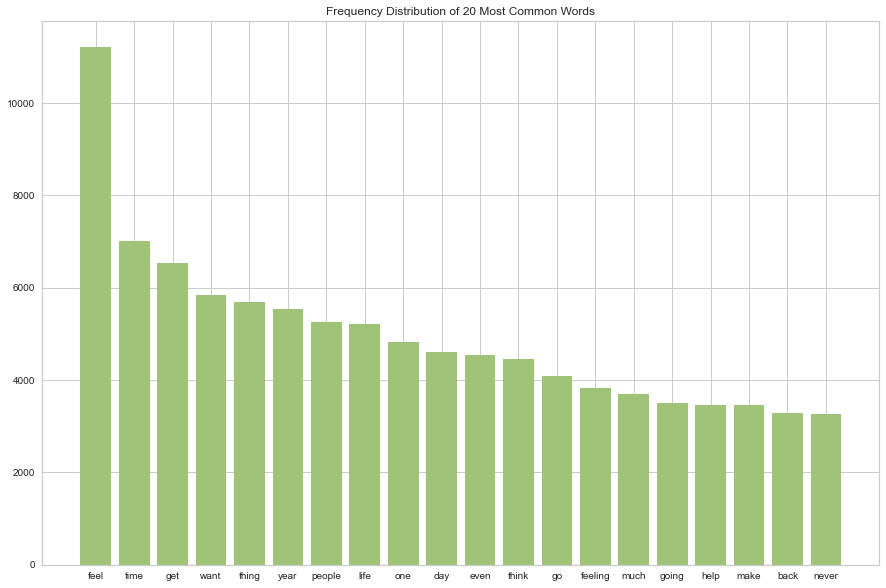

In [29]:
'''defining the corpus from cleaned text'''
corpus = []


'''creating exclusion list & updating corpus'''
for document in df['text']:
    exclude_list = ['anyone', 'else', 'like', "dont", 'know', "im", 'new', '[]', 'ive', 'really', 'would']
    for text in document:
        if text not in exclude_list:
            corpus.append(text)


'''Frequency distribution'''
%matplotlib inline
fd = nltk.FreqDist(corpus)
freq_W = fd.most_common(20)

def Convert(tup, di):
    di = dict(tup)
    return di
      
di = {}
freq_dict = Convert(freq_W, di)

print(freq_dict)

fig = plt.figure(figsize=(15,10))
plt.title("Frequency Distribution of 20 Most Common Words")
plt.bar(freq_dict.keys(), freq_dict.values(), color='g')
plt.savefig("freq dist.png", dpi=300)
plt.show(fig)


In [11]:
'''printing a list of concordances for the word, "feel" '''
text = nltk.Text(corpus)
concordance_list = text.concordance_list("feel", lines=20)
for entry in concordance_list:
    print(entry.line)
    
    
'''finding collocations for most common words'''
finder = nltk.collocations.QuadgramCollocationFinder.from_words(text)
finder_list = finder.ngram_fd.most_common(20)
for find in finder_list:
    print(find)

ime finally anything absolutely sick feel killing 2 kid couldnt couldnt hurt f
l killing 2 kid couldnt couldnt hurt feel failure always high hope life disapp
ore shouldve taken life chance still feel way told take life least put long fi
hing good come saying bad saying bad feel problem say tried many way non worke
 people tend little bit needy easily feel forgot unappreciated guy express wee
ell maybe fucked either way cant say feel better excuse rabid complaint litera
 someone reach recently living began feel chore everyday go motion hard also f
l chore everyday go motion hard also feel burden everyone around somehow alway
r anyways wondering advice something feel awful tired feeling way fix want hap
ful tired feeling way fix want happy feel unattainable right hello christian 2
t even dreaming working hard praying feel unfair painful since never made anyt
osen right truthful path matter make feel even angrier alone devastatedi keep 
mine gotten therapy recognized thing feel feel allow

## POS tags, and their distribution

In [57]:
'''Building a dataframe with POS tagged tokens'''
text = df['text']
pos_df = pd.DataFrame()

#Text classification: pos tagging
pos_tagged_text = []

for ele in text:
    pos_tagged_text.append(nltk.pos_tag(ele))

pos_df['pos_text'] = pos_tagged_text

pos_df['pos_text']

0       [(able, JJ), (control, NN), (2, CD), (day, NN)...
1       [(diagnosed, VBN), (depression, NN), (anxiety,...
2       [(ive, NN), (depressed, VBD), (since, IN), (16...
3       [(remember, VB), (exactly, RB), (last, JJ), (t...
4       [(unfortunate, JJ), (circumstance, NN), (produ...
                              ...                        
9486    [(seek, NN), (help, NN), (know, VB), (might, M...
9487    [(know, VB), (sound, JJ), (strange, JJ), (thin...
9488    [(good, JJ), (see, NN), (section, NN), (kind, ...
9489    [(maybe, RB), (start, VB), (need, NN), (defini...
9490    [(told, VBN), (dissociation, NN), (get, VB), (...
Name: pos_text, Length: 9491, dtype: object

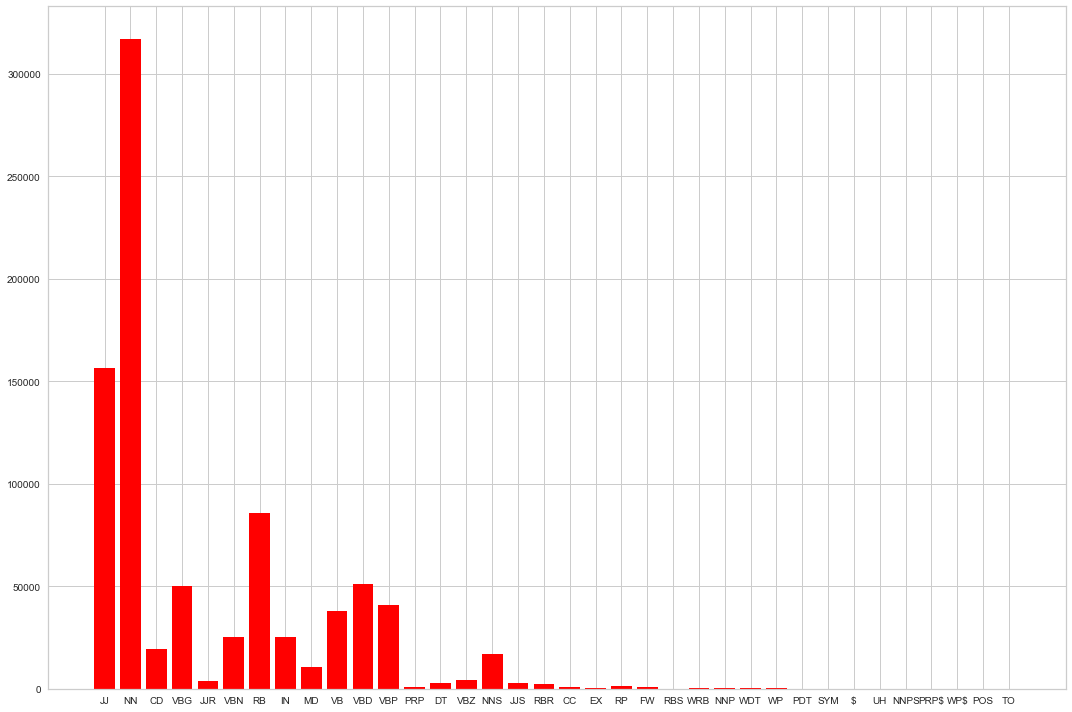

In [61]:
'''creating a dictionary to store counts of unique POS tags'''
pos_list = []
for row in pos_df['pos_text']:
    for tup in row:
        if tup[1] not in pos_list:
            pos_list.append(tup[1])
            
pos_dict = {}
for item in pos_list:
    pos_dict[item] = 0
    for row in pos_df['pos_text']:
        for tup in row:
            if tup[1] == item:
                pos_dict[item] += 1
                

'''Plotting the counts'''
%matplotlib inline

fig = plt.figure(figsize=(15,10))
plt.bar(pos_dict.keys(), pos_dict.values(), color='red')
plt.tight_layout()
plt.savefig("pos_dist.png", dpi=300)
plt.show()
        
    

# Feature Exploration

Process:
- Vectorization
- Generate WordCloud for better visualization
- Obtain bar graph of the 50 most common features
- Dimensionality reduction for transforming sparse data & visualization of features
- Visualizing class distribution & balancing out samples in each class (2 methods are compared)
    - RandomOverSampling
    - RandomUnderSampling

## Vectorization

In [63]:
'''defining vectorizer'''
docs = df['text'].astype(str).dropna()
vectorizer = TfidfVectorizer(stop_words='english', 
                             min_df = 5,
                             ngram_range = (1,2),
                             use_idf = True,
                             max_df = 0.5, 
                             smooth_idf=True)


'''vectorizing text, and mapping the labels'''
label_map = {0: 'Depression',
             1: 'PTSD',
             2: 'CPTSD',
             3: 'Borderline',
             4: 'Bipolar',
             5: 'Dissociation'}

X = vectorizer.fit_transform(docs).toarray()
y = df['label'].values
y_label = df['label'].map(label_map)


print(X.shape)
y.shape

(9491, 22482)


(9491,)

In [64]:
print(X)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## WordCloud Generation

This WordCloud was a challenge due to the .get_feature_names() method returning duplicate words with an apostrophy at the end. I specified the redundancies to exclude by studying the WordCloud, and the results look much cleaner and more insightful than before. The result is also consistent with the frequency distribution I did on the corpus earlier.

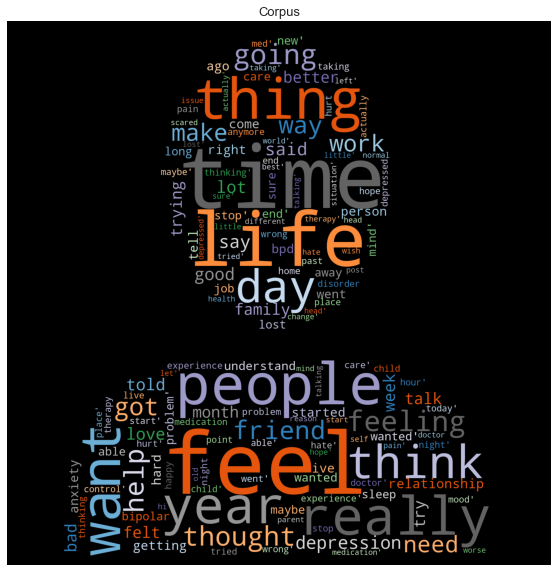

In [119]:
'''exclusion list of redundant features (predominantly duplicate words with an apostrophy)'''
exclude_list = ['anyone', 'else', "feel'", 'like',"like'", 
                "dont", "dont'", 'know', "im'","im", 'new', "time'", 
                "people'", "year'", "life'","ive'", "know'", "think'", 
                "day'", "thing'", "really'", "friend'", "want'", "said'",
                "make'", "thought'", "told'", "help'", "going'", "dindt'", 
                "felt'", "good'", "didnt'", "depression'", "way'", "got'", 
                "week'", "month'", "say'", "try'", "work'", "feeling'", "lot'",
                "relationship'", "talk'", "family'", "tell'", "anxiety'", "need'", "long'",
                "bad'", "love'", "self'", "away'", "better'", "right'", "doesnt'", "right'", "point'", "come'",
                "job'", "issue'", "getting'", "hard'", "mental'", "bipolar'", "started'", "person'",
                "home'", "wwanted'", "bpd'", "happy'", "leave'", "past'", "live'", 
                "trying'", "house'", "understand'", "anymore'", "feel abit", "sleep'"]


'''getting the names of features and storing them into a new list with the exclusion in place'''
features = vectorizer.get_feature_names()
features_list = []
for feature in features:
    if feature not in exclude_list:
        features_list.append(feature)

        
# Import image to np.array
mask = np.array(Image.open('user.png'))
        
'''defining method to generate a WordCloud'''
def generate_wordcloud(data, title):
    cloud = WordCloud(width=400,
                      height=330,
                      max_words=150,
                      colormap='tab20c',
                      stopwords=exclude_list,
                      collocations=False, 
                      mask=mask).generate_from_text(data)
    plt.figure(figsize=(14,10))
    plt.imshow(cloud)
    plt.axis('off')
    plt.title(title, fontsize=13)
    plt.savefig("wordcloud.png", dpi=300)
    plt.show()
    
generate_wordcloud(str(features_list), 'Corpus')

In [34]:
'''checking for null values'''
pd.isnull(df).sum() > 0

label    False
text     False
dtype: bool

## Visualizing Top 50 Features

Note that some features are bigrams, as specified in the vectorizer under the n_gram_range parameter.

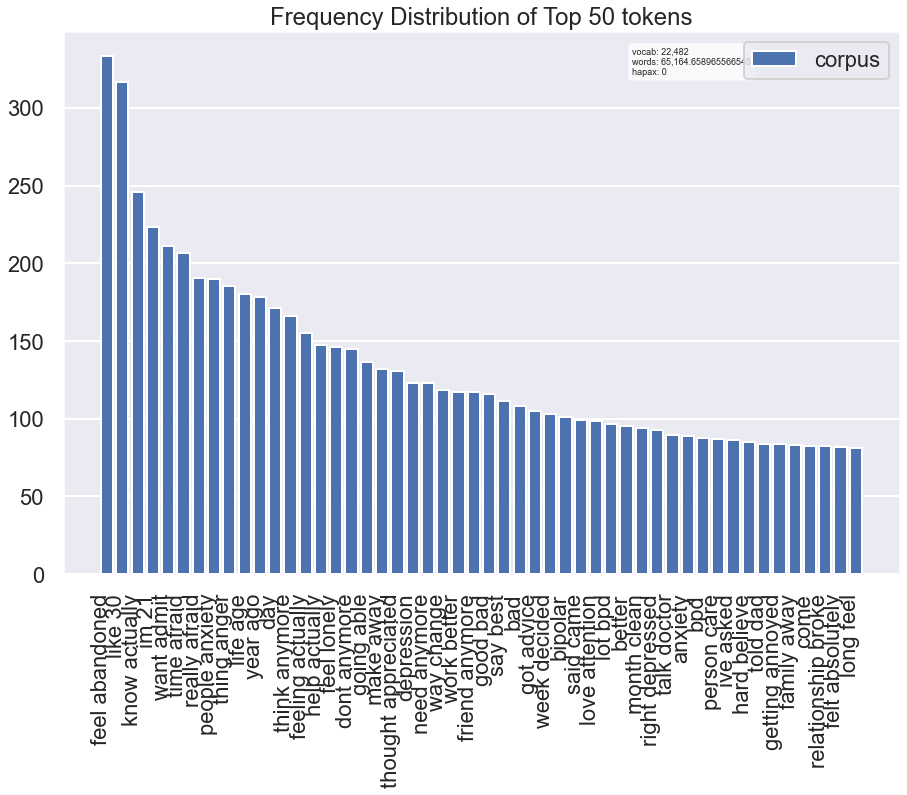

<Figure size 432x288 with 0 Axes>

In [122]:
'''Yellowbrick helps visualize features really easily!'''
features = vectorizer.get_feature_names()
visualizer = FreqDistVisualizer(features=features_list, orient='v', size=(1080,720))
visualizer.fit(X)
visualizer.show()
plt.tight_layout()
plt.savefig('top_50.png', dpi=500)

## PCA Dimensionality Reduction


<Figure size 576x432 with 0 Axes>

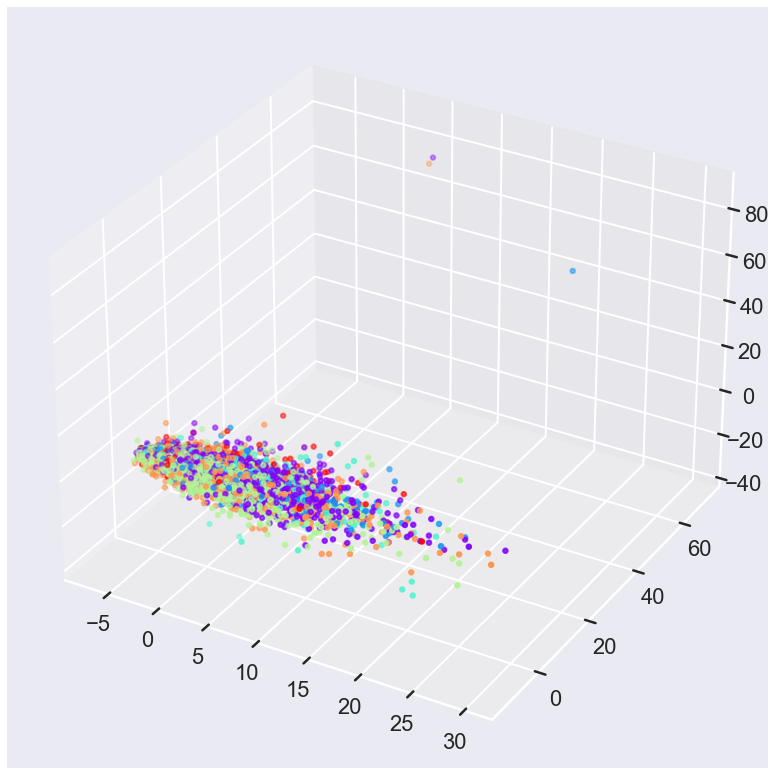

In [123]:
ss = StandardScaler()
pca = PCA(n_components=10)
data = ss.fit_transform(X)

pca_transformed = pca.fit_transform(data)

plt.figure(figsize=(8,6))
sns.set(style='darkgrid', context='poster', rc={'figure.figsize':(20,14)})
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_transformed[:,0], pca_transformed[:,5], pca_transformed[:,9], c=y, cmap='rainbow')
plt.savefig("PCA.png", dpi=300)
plt.show()

## Evaluation

The results below show that linear modeling may be a poor fit for this dataset. 

In [93]:
X_train, X_test, y_train, y_test = train_test_split(pca_transformed, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    random_state = 3)

linear = LogisticRegression()
linear.fit(X_train, y_train)
y_pred = linear.predict(X_test)


print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred, average='macro'))
print(recall_score(y_test, y_pred, average='macro'))
print(f1_score(y_test, y_pred, average='macro'))




0.49508426966292135
0.4891645362890556
0.44836555786888144
0.4506117256732531


## Dimensionality Reduction with UMAP

The plot below shows that I was able to reduce the dimensions of the dataset and achieved decent separation of the classes. Note that this has been reduced down to 2-dimensions, and would likely achieve a more robust figure when expanded slightly. Let's take a closer look.

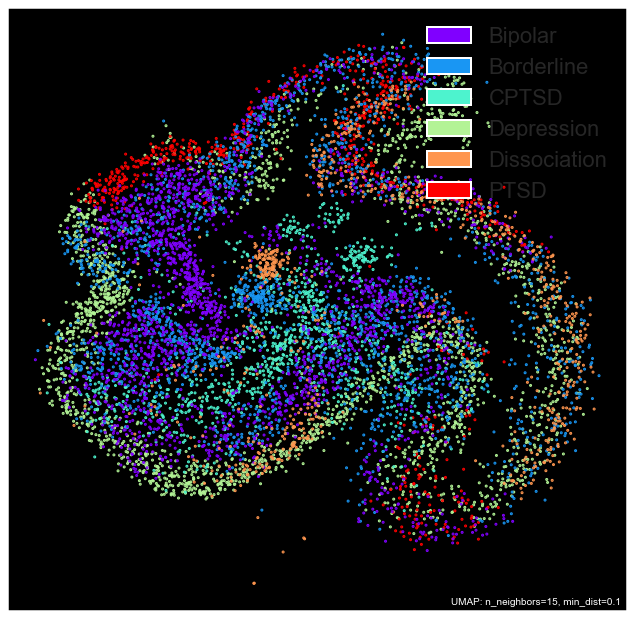

In [106]:
'''default for UMAP is 2-dimensions, at 15 neighborhoods and 0.1 min_dist.'''
mapper = umap.UMAP().fit(X)

%matplotlib inline
umap.plot.points(mapper, labels=y_label, theme='fire')
plt.savefig('dimension_reduced.png', dpi=500)

## Evaluation

The results show that non-linear method of transformation and modeling achieves better classification metrics compared to the linear method.  

In [108]:
data_umap = umap.UMAP().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(data_umap, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    random_state = 3)

KNN = KNeighborsClassifier()
KNN.fit(X_train, y_train)
y_pred = KNN.predict(X_test)


print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred, average='macro'))
print(recall_score(y_test, y_pred, average='macro'))
print(f1_score(y_test, y_pred, average='macro'))

0.6485252808988764
0.6090634148469819
0.5953275703783536
0.599101457234081


## Feature Exploration Tool with BokehJS 

By hovering over this plot below, Bokeh allows us to take a much more intimate look at the features. By mapping the appropriate labels we can easily visualize where in the matrix the classes are clustered. 

In [109]:
hover_data = pd.DataFrame({'index': np.arange(len(y)),
                           'label': y})
hover_data['item'] = hover_data.label.map({0:'depression',
                                           1:'ptsd',
                                           2:'cptsd',
                                           3:'bpd',
                                           4:'bipolar',
                                           5:'dissociation'})

umap.plot.output_notebook()
p = umap.plot.interactive(mapper, labels=y, hover_data=hover_data, point_size=2)
umap.plot.show(p)

Loading BokehJS ...

## Feature Relationships (edge-bundling) Visualization

These adjacent relationships of embeddings show distinct branches with relatively clean bundling. This shows that the embedding achieves a decent spread over the matrix, and will likely yield good results. 

C:\Users\chung\anaconda3\envs\TestEnv\lib\site-packages\umap\plot.py:855: UserWarning: Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!
  "Hammer edge bundling is expensive for large graphs!\n"


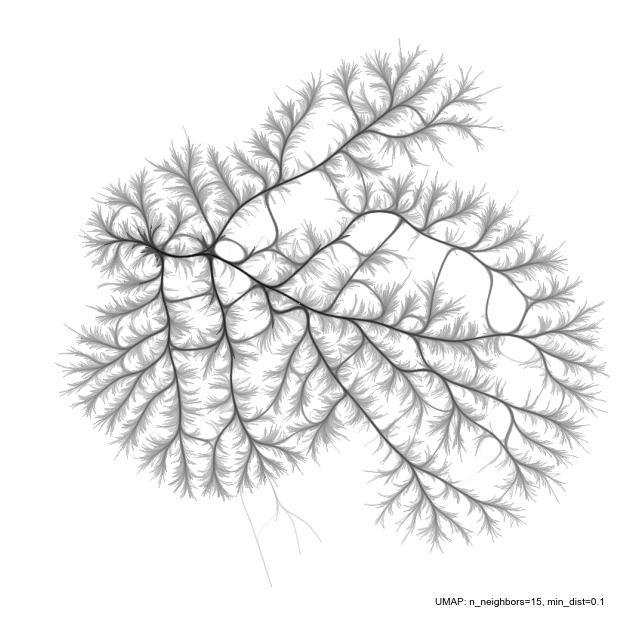

In [110]:
%matplotlib inline
umap.plot.connectivity(
    mapper, 
    edge_bundling="hammer",
    cmap="rainbow",
    labels=y,
    show_points=True
)
plt.savefig('comorbidity.png', dpi=500)

## Class Distribution Visualization

However, when taken a closer look, we see a very imbalanced distribution of classes. This is due to the lack of availability of documents for certain labels, while others had plenty. Normalization of these classes is the next appropriate step.

Text(0.5, 1.0, 'Classes Distribution')

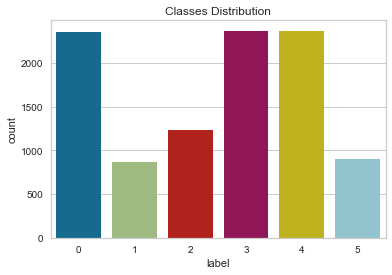

In [58]:
sns.countplot(x='label', data=df)
plt.title("Classes Distribution")

## Balancing Out Class Distribution (2 methods)

In the next notebook, I compare the performances of two different methods of random sampling - starting with Random Over Sampler, then Random Under Sampler. I put each method through a trial of 8 different modeling techniques-- both linear and non-linear methods are implemented.

In [59]:
'''Random Over Sampling is a method that evens out the distribution of your classes by inflating the underrepresented classes.'''
ovs = RandomOverSampler(random_state=42)
X_res, y_res = ovs.fit_resample(X,y)


'''Random Under Sampling is the converse of ROS, where the overrepresented classes are reduced to match the underrepresented classes'''
ous = RandomUnderSampler(random_state=42)
X_res_b, y_res_b = ous.fit_resample(X,y)

In [60]:
print("original class counts: " + str(pd.value_counts(y.ravel())))
print("new class counts: " + str(pd.value_counts(y_res.ravel())))
print("new class counts: " + str(pd.value_counts(y_res_b.ravel())))

original class counts: 4    2370
3    2364
0    2361
2    1228
5     906
1     862
dtype: int64
new class counts: 0    2370
1    2370
2    2370
3    2370
4    2370
5    2370
dtype: int64
new class counts: 0    862
4    862
1    862
5    862
2    862
3    862
dtype: int64
